# Evaluate on the Test set

In [1]:
from pipeline import Pipeline, plot_confusion_matrix, characters
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(repo_id="Pikurrot/yolo11n-licenseplates", filename="yolo11n_licenseplates.pt")
pipeline = Pipeline(model_path)
result = pipeline("DatasetYolo/test/images/", rec_thresh=0)

[2024/10/13 18:54:46] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/eric/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/eric/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length

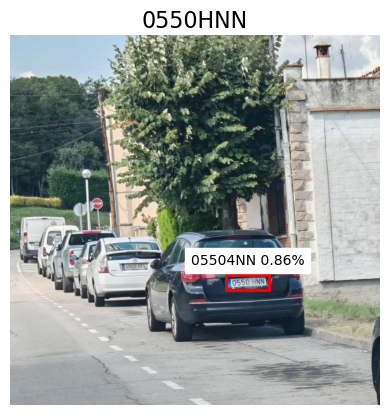

In [2]:
pipeline.plot_result(result[0])

In [3]:
metrics = pipeline.evaluate(result)
print("Accuracy: ", metrics["avg_accuracy"])
print("ANLS: ", metrics["avg_anls"])
print("Avg. confidence: ", metrics["avg_conf"])
print("Char. Precision: ", metrics["precision"])
print("Char. Recall: ", metrics["recall"])
print("Char. F1: ", metrics["f1"])
print("Most confused characters: ", " ".join(
	["("+",".join(chars)+")" for chars, _ in metrics["most_confused_chars"][:5]]))

Accuracy:  0.5714285714285714
ANLS:  0.8351757369614513
Avg. confidence:  0.8358053313473202
Char. Precision:  0.8439306358381503
Char. Recall:  0.8439306358381503
Char. F1:  0.8439306358381503
Most confused characters:  (9,7) (B,J) (D,3) (D,6) (F,U)


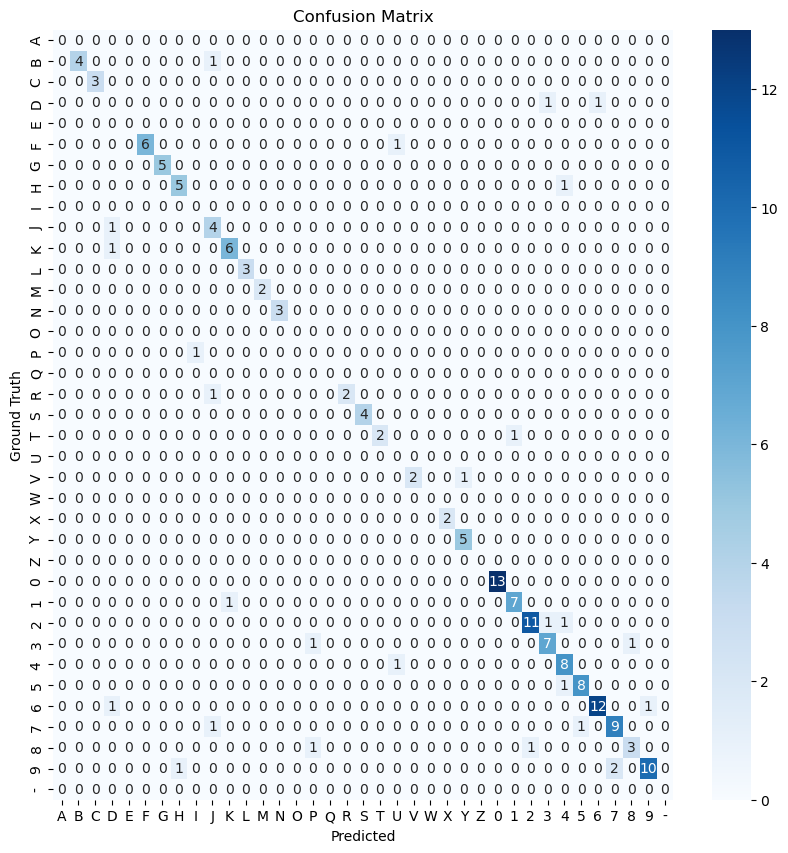

In [4]:
plot_confusion_matrix(metrics["conf_matrix"], characters)

# Evaluate on provided Test set

In [5]:
result_frontal = pipeline("Test/Frontal/", cache_process=True)
metrics_frontal = pipeline.evaluate(result_frontal)
print("Accuracy: ", metrics_frontal["avg_accuracy"])
print("ANLS: ", metrics_frontal["avg_anls"])
print("Avg. confidence: ", metrics_frontal["avg_conf"])
print("Char. Precision: ", metrics_frontal["precision"])
print("Char. Recall: ", metrics_frontal["recall"])
print("Char. F1: ", metrics_frontal["f1"])
print("Most confused characters: ", " ".join(
	["("+",".join(chars)+")" for chars, _ in metrics_frontal["most_confused_chars"][:5]]))


image 1/15 /media/eric/D/repos/ANPR-GIA/Test/Frontal/1062FNT.jpg: 384x640 1 License Plate, 87.6ms
image 2/15 /media/eric/D/repos/ANPR-GIA/Test/Frontal/1565HTS.jpg: 384x640 1 License Plate, 59.3ms
image 3/15 /media/eric/D/repos/ANPR-GIA/Test/Frontal/2153GYX.jpg: 384x640 1 License Plate, 56.4ms
image 4/15 /media/eric/D/repos/ANPR-GIA/Test/Frontal/2929KXJ.jpg: 384x640 1 License Plate, 49.9ms
image 5/15 /media/eric/D/repos/ANPR-GIA/Test/Frontal/3340JMF.jpg: 384x640 1 License Plate, 60.6ms
image 6/15 /media/eric/D/repos/ANPR-GIA/Test/Frontal/3587DCX.jpg: 384x640 1 License Plate, 54.1ms
image 7/15 /media/eric/D/repos/ANPR-GIA/Test/Frontal/4674FHC.jpg: 384x640 1 License Plate, 55.9ms
image 8/15 /media/eric/D/repos/ANPR-GIA/Test/Frontal/5275HGY.jpg: 384x640 1 License Plate, 55.1ms
image 9/15 /media/eric/D/repos/ANPR-GIA/Test/Frontal/5488LKV.jpg: 384x640 1 License Plate, 54.0ms
image 10/15 /media/eric/D/repos/ANPR-GIA/Test/Frontal/5796DKP.jpg: 384x640 1 License Plate, 52.6ms
image 11/15 /media

In [15]:
result_lateral = pipeline("Test/Lateral/")
metrics_lateral = pipeline.evaluate(result_lateral)
print("Accuracy: ", metrics_lateral["avg_accuracy"])
print("ANLS: ", metrics_lateral["avg_anls"])
print("Avg. confidence: ", metrics_lateral["avg_conf"])
print("Char. Precision: ", metrics_lateral["precision"])
print("Char. Recall: ", metrics_lateral["recall"])
print("Char. F1: ", metrics_lateral["f1"])
print("Most confused characters: ", " ".join(
	["("+",".join(chars)+")" for chars, _ in metrics_lateral["most_confused_chars"][:5]]))


image 1/17 /media/eric/D/repos/ANPR-GIA/Test/Lateral/0182GLK.jpg: 384x640 1 License Plate, 59.7ms
image 2/17 /media/eric/D/repos/ANPR-GIA/Test/Lateral/0907JRF.jpg: 384x640 1 License Plate, 49.1ms
image 3/17 /media/eric/D/repos/ANPR-GIA/Test/Lateral/1498JBZ.jpg: 384x640 1 License Plate, 48.1ms
image 4/17 /media/eric/D/repos/ANPR-GIA/Test/Lateral/1556GMZ.jpg: 384x640 1 License Plate, 50.4ms
image 5/17 /media/eric/D/repos/ANPR-GIA/Test/Lateral/2344KJP.jpg: 384x640 1 License Plate, 55.7ms
image 6/17 /media/eric/D/repos/ANPR-GIA/Test/Lateral/3044JMB.jpg: 384x640 2 License Plates, 57.3ms
image 7/17 /media/eric/D/repos/ANPR-GIA/Test/Lateral/3587DCX.jpg: 384x640 1 License Plate, 53.6ms
image 8/17 /media/eric/D/repos/ANPR-GIA/Test/Lateral/3660CRT.jpg: 384x640 1 License Plate, 53.3ms
image 9/17 /media/eric/D/repos/ANPR-GIA/Test/Lateral/4674FHC.jpg: 384x640 1 License Plate, 50.8ms
image 10/17 /media/eric/D/repos/ANPR-GIA/Test/Lateral/5275HGY.jpg: 384x640 1 License Plate, 51.9ms
image 11/17 /medi